## ANLY 5336 Analytics Project: COVID-19 Forecasting
Author: John Courtright

This project works through data from the New York Time's COVID-19 datasets. Link: https://github.com/nytimes/covid-19-data

This notebook constructs time-series models on Travis County's weekly case and death reporting over 3 years (from March 2020 to March 2023).

In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

In [2]:
# Data Sets
travis_df = pd.read_csv('https://raw.githubusercontent.com/john-courtright/TXST-ANLY-5336-Courtright/refs/heads/main/Covid/travis_county_covid_weekly.csv')
travis_mask = pd.read_csv('https://raw.githubusercontent.com/john-courtright/TXST-ANLY-5336-Courtright/refs/heads/main/Covid/travis_county_mask_usage.csv')

In [3]:
travis_df['date'] = pd.to_datetime(travis_df['date'])
travis_df.set_index('date', inplace=True)

In [4]:
# Extract the 4 Time-Series Chunks
cases_df = travis_df['cases']
cases100k_df = travis_df['cases_avg_per_100k']
deaths_df = travis_df['deaths']
deaths100k_df = travis_df['deaths_avg_per_100k']

In [5]:
# Confirm all clean
for name, s in {
    "cases": cases_df,
    "cases100k": cases100k_df,
    "deaths": deaths_df,
    "deaths100k": deaths100k_df
}.items():
    print(f"{name}: {s.isna().sum()} missing values")

cases: 0 missing values
cases100k: 0 missing values
deaths: 0 missing values
deaths100k: 0 missing values



Decomposing: Weekly Cases


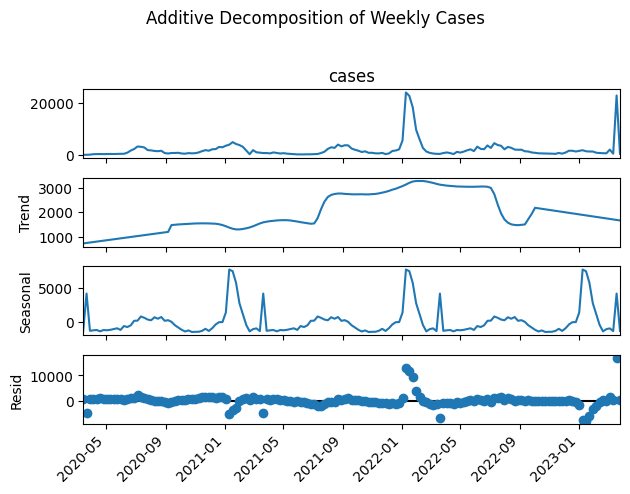


Decomposing: Weekly Cases per 100k


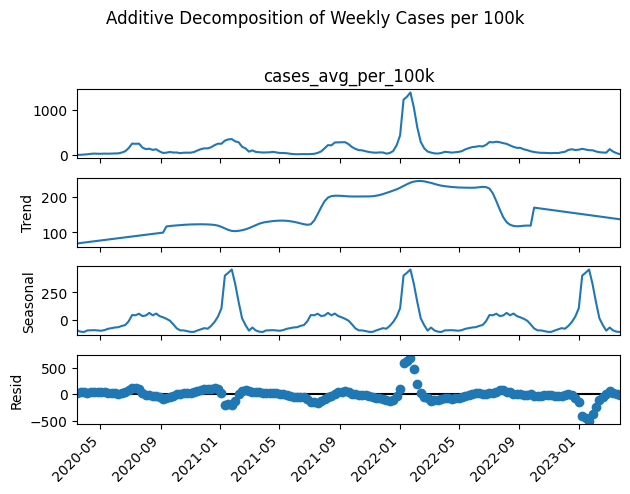


Decomposing: Weekly Deaths


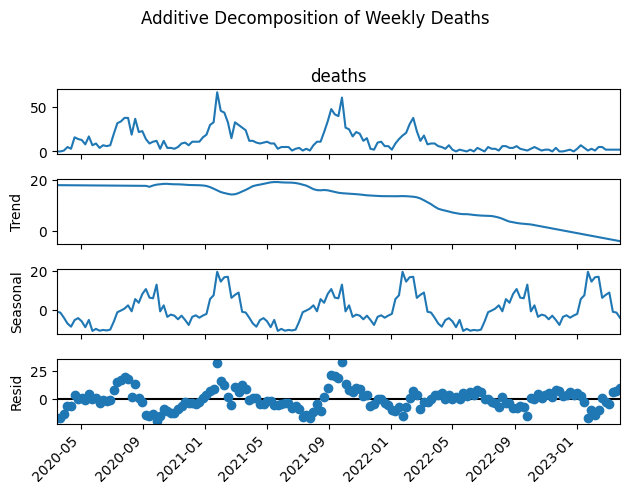


Decomposing: Weekly Deaths per 100k


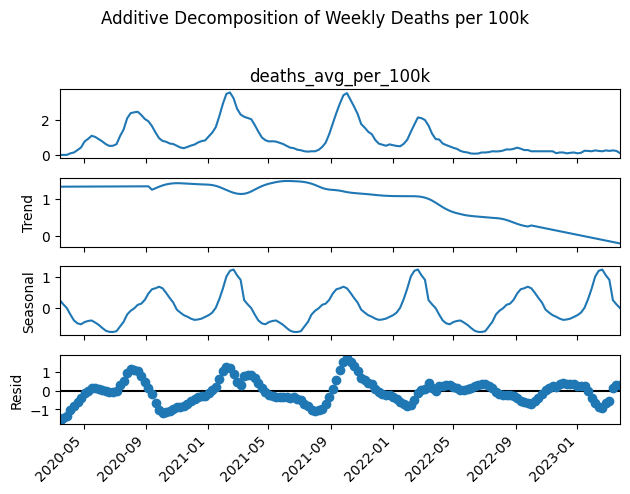

In [6]:
# Decompose and plot
series_dict = {
    "Weekly Cases": cases_df,
    "Weekly Cases per 100k": cases100k_df,
    "Weekly Deaths": deaths_df,
    "Weekly Deaths per 100k": deaths100k_df
}

for name, series in series_dict.items():
    print(f"\nDecomposing: {name}")
    
    additive = seasonal_decompose(series, model='additive', extrapolate_trend='freq')
    fig1 = additive.plot()
    fig1.suptitle(f'Additive Decomposition of {name}', y=1.02)
    for ax in fig1.axes:
        plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
    fig1.tight_layout()
    plt.show()
    
    '''
    multiplicative = seasonal_decompose(series, model='multiplicative', extrapolate_trend='freq')
    fig2 = multiplicative.plot()
    fig2.suptitle(f'Multiplicative Decomposition of {name}', y=1.02)
    for ax in fig2.axes:
        plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
    fig2.tight_layout()
    '''
    plt.show()


=== WEEKLY CASES ===
Cross-Validation RMSE: 4812.28
Historical Peak: 23952.00 on 2022-01-09


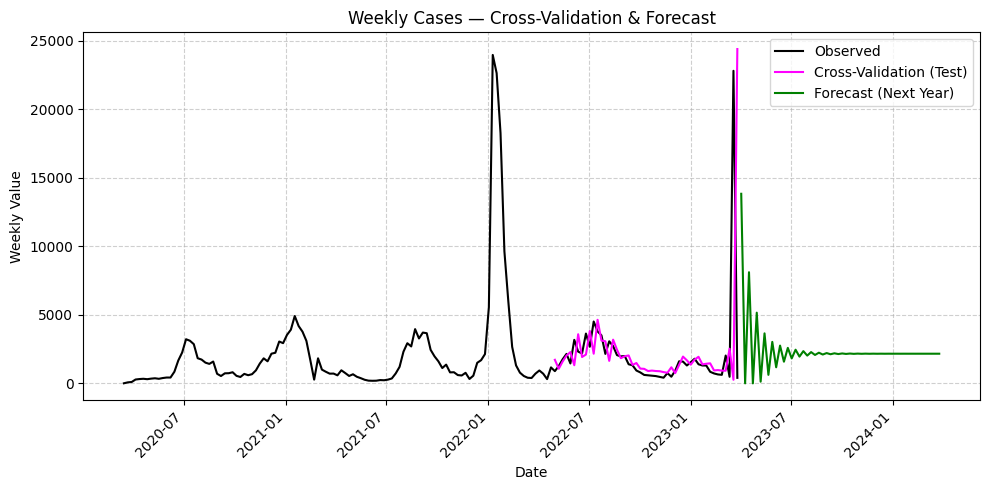


=== WEEKLY CASES PER 100K ===
Cross-Validation RMSE: 26.91
Historical Peak: 1383.39 on 2022-01-23


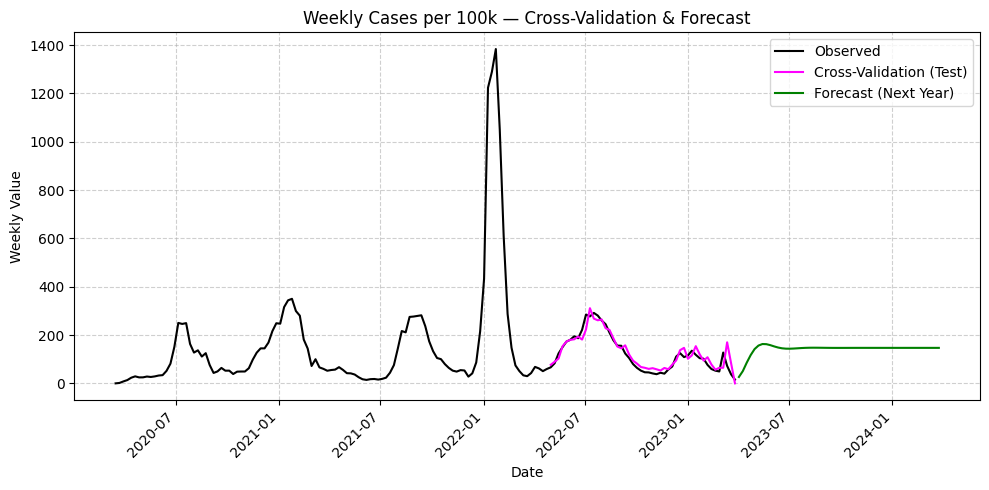


=== WEEKLY DEATHS ===
Cross-Validation RMSE: 3.11
Historical Peak: 67.00 on 2021-01-24


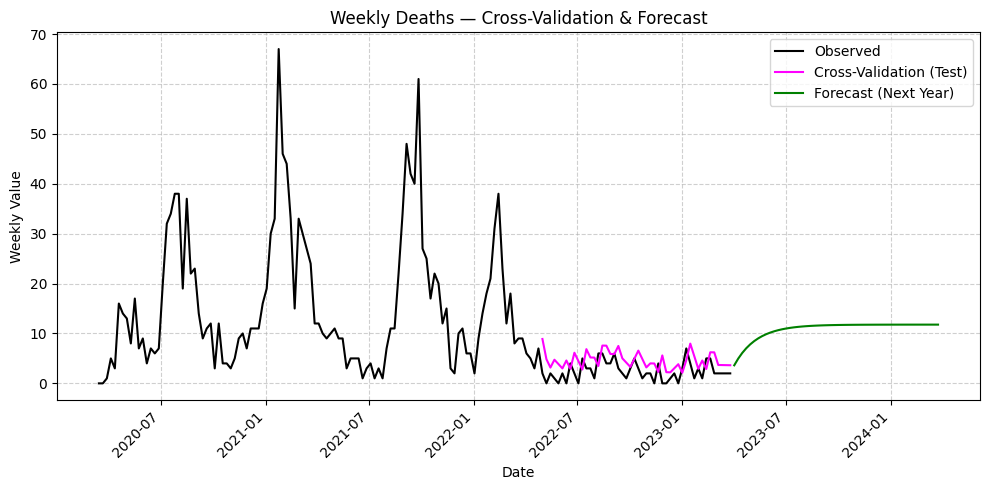


=== WEEKLY DEATHS PER 100K ===
Cross-Validation RMSE: 0.09
Historical Peak: 3.62 on 2021-02-14


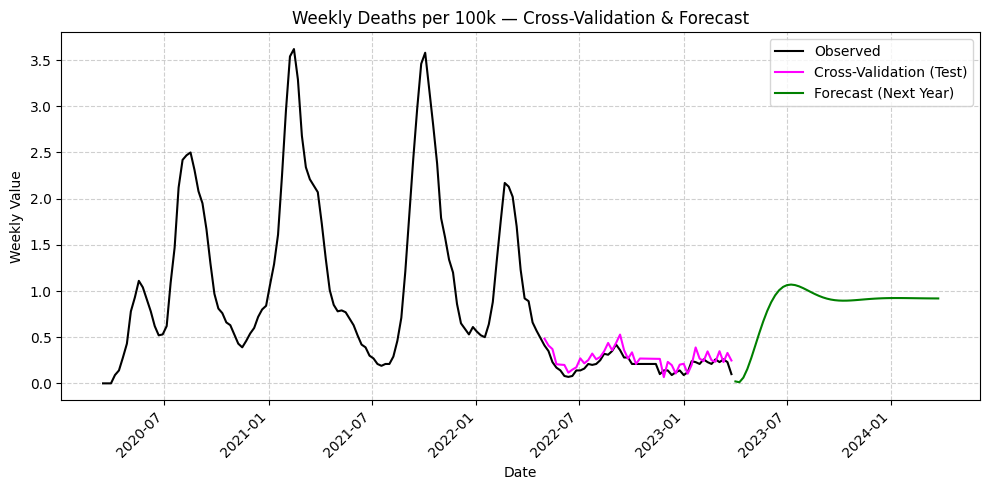

In [13]:
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from sklearn import metrics

# --- Helper function to cross-validate and forecast ---
def cross_validate_forecast(series, title, forecast_weeks=52, max_lag=13):
    print(f"\n=== {title.upper()} ===")
    
    # Split the data
    train = series.iloc[:int(0.7 * len(series))]
    test = series.iloc[int(0.7 * len(series)):]
    
    train_list = train.tolist()
    predictions = []
    
    # --- Cross-validation (rolling forecast) ---
    for i in range(len(test)):
        sel = ar_select_order(train_list, maxlag=max_lag, old_names=False)
        model_fit = sel.model.fit()
        pred = model_fit.predict(start=len(train_list), end=len(train_list), dynamic=False)
        predictions.append(pred[0])
        train_list.append(test.iloc[i])
    
    cross_val = pd.Series(predictions, index=test.index)
    
    # --- RMSE ---
    rmse_cv = np.sqrt(metrics.mean_squared_error(test, cross_val))
    print(f"Cross-Validation RMSE: {rmse_cv:.2f}")
    
    # --- One-year forecast (next 52 weeks) ---
    future_train = series.tolist()
    last_date = series.index[-1]
    future_dates = pd.date_range(start=last_date + pd.Timedelta(weeks=1), periods=forecast_weeks, freq='W')
    
    future_predictions = []
    for i in range(forecast_weeks):
        sel = ar_select_order(future_train, maxlag=max_lag, old_names=False)
        model_fit = sel.model.fit()
        pred = model_fit.predict(start=len(future_train), end=len(future_train), dynamic=False)
        if pred[0] < 0: pred[0] = 0
        future_predictions.append(pred[0])
        future_train.append(pred[0])
    
    future_pred_series = pd.Series(future_predictions, index=future_dates)
    
    # Calculate max value of historical data and annotate with date
    max_hist_val = series.max()
    max_hist_date = series.idxmax()
    print(f"Historical Peak: {max_hist_val:.2f} on {max_hist_date.date()}")
    
    
    # --- Plot ---
    plt.figure(figsize=(10,5))
    plt.plot(series, label='Observed', color='black')
    plt.plot(cross_val, color='magenta', label='Cross-Validation (Test)')
    plt.plot(future_pred_series, color='green', label='Forecast (Next Year)')
    plt.title(f'{title} — Cross-Validation & Forecast')
    plt.xlabel('Date')
    plt.ylabel('Weekly Value')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
    return cross_val, future_pred_series, rmse_cv

# --- Run for all 4 series ---
results = {}

for name, data in {
    "Weekly Cases": cases_df,
    "Weekly Cases per 100k": cases100k_df,
    "Weekly Deaths": deaths_df,
    "Weekly Deaths per 100k": deaths100k_df
}.items():
    cross_val, future_pred, rmse = cross_validate_forecast(data, name)
    results[name] = {"cv": cross_val, "future": future_pred, "rmse": rmse}


In [8]:
# Load workbook of hospital data
from openpyxl import load_workbook

path = 'Combined Hospital Data over Time by TSA Region.xlsx'

wb = load_workbook(filename=path, read_only=True)

# Get the list of sheet names
sheet_names_list = wb.sheetnames
sheet_names_list

['COVID-19 Hospitalizations',
 'COVID Hospitalizations (%)',
 'Adult COVID-19 General',
 'Adult COVID-19 ICU',
 'Pediatric COVID-19',
 'COVID-19 Admits 24HR',
 'Total Hospital Capacity',
 'COVID % Capacity',
 'Total Staffed Inpatient',
 'Total Occupied Beds',
 'Total Available Beds',
 'ICU Beds Occupied',
 'Adult ICU Beds Available',
 'Pediatric ICU Beds Available',
 'COVID19 Patients on Ventilators',
 'Available Ventilators']

In [9]:
# Read sheets into DataFrames
sheets_dict = {}

# COVID-19 Hospitalizations (skip 2 rows)
# COVID Hospitalizations (%) (skip 3 rows)
# Adult COVID-19 General () (skip 2 rows)
# Adult COVID-19 ICU (skip 2 rows)
# Pediatric COVID-19 (skip 2 rows)
# COVID % Capacity (skip 2 rows)

for sheet_name in sheet_names_list:
    if sheet_name == 'COVID-19 Hospitalizations':
        df = pd.read_excel(path, sheet_name=sheet_name, skiprows=2)
    elif sheet_name == 'COVID Hospitalizations (%)':
        df = pd.read_excel(path, sheet_name=sheet_name, skiprows=3)
    else:
        df = pd.read_excel(path, sheet_name=sheet_name, skiprows=2)
    sheets_dict[sheet_name] = df

sheets_dict.keys()

dict_keys(['COVID-19 Hospitalizations', 'COVID Hospitalizations (%)', 'Adult COVID-19 General', 'Adult COVID-19 ICU', 'Pediatric COVID-19', 'COVID-19 Admits 24HR', 'Total Hospital Capacity', 'COVID % Capacity', 'Total Staffed Inpatient', 'Total Occupied Beds', 'Total Available Beds', 'ICU Beds Occupied', 'Adult ICU Beds Available', 'Pediatric ICU Beds Available', 'COVID19 Patients on Ventilators', 'Available Ventilators'])

In [10]:
# We only want Travis County Data, which is TSA ID = 'O' or TSA AREA = 'Austin'
# We also need to flip the data for time series analysis, and resample to weekly frequency

travis_hospital_data = {}

for sheet_name, df in sheets_dict.items():
    
    # Filter for Travis County (TSA ID = 'O' or TSA AREA = 'Austin')
    if 'TSA ID' in df.columns:
        travis_df = df[df['TSA ID'] == 'O']
    elif 'TSA AREA' in df.columns:
        travis_df = df[df['TSA AREA'] == 'Austin']
    else:
        continue  # Skip if neither column exists

    # Drop unnecessary columns
    travis_df = travis_df.drop(columns=['TSA ID', 'TSA AREA'], errors='ignore')

    # Transpose the DataFrame to have dates as index
    travis_df = travis_df.set_index(travis_df.columns[0]).transpose()

    # Set headers, first row is now header, first column is date, second is data
    travis_df.columns = travis_df.iloc[0]
    travis_df = travis_df.drop(travis_df.index[0])

    # Convert index to datetime
    travis_df.index = pd.to_datetime(travis_df.index)

    # --- FIX: Convert percentage strings to numeric ---
    # Detect columns where at least one entry contains a "%"
    # This has to be done for the COVID percentages
    for col in travis_df.columns:
        if travis_df[col].astype(str).str.contains('%').any():
            travis_df[col] = (
                travis_df[col]
                .astype(str)
                .str.replace('%', '', regex=True)
                .replace('', np.nan)     # empty cells become NaN
                .astype(float) / 100.0    # convert to decimal
            )

    # Convert data to numeric, forcing errors to NaN
    travis_df = travis_df.apply(pd.to_numeric, errors='coerce')

    # Impute missing values with forward fill
    travis_df = travis_df.ffill()

    # If any NaNs remain (just double checking), fill with median of the column
    travis_df = travis_df.fillna(travis_df.median())

    # Resample to weekly frequency (to match other time series)
    travis_df = travis_df.resample('W').sum()

    # Sort the rows by date ascending
    # Idk why but some dates are out of order
    travis_df = travis_df.sort_index()

    # Store in dictionary
    travis_hospital_data[sheet_name] = travis_df

travis_hospital_data.keys()

dict_keys(['COVID-19 Hospitalizations', 'COVID Hospitalizations (%)', 'Adult COVID-19 General', 'Adult COVID-19 ICU', 'Pediatric COVID-19', 'COVID-19 Admits 24HR', 'Total Hospital Capacity', 'COVID % Capacity', 'Total Staffed Inpatient', 'Total Occupied Beds', 'Total Available Beds', 'ICU Beds Occupied', 'Adult ICU Beds Available', 'Pediatric ICU Beds Available', 'COVID19 Patients on Ventilators', 'Available Ventilators'])

In [11]:
for name, data in travis_hospital_data.items():
    print(name, "NaNs:", data.iloc[:,0].isna().sum(), "min:", data.iloc[:,0].min(), "max:", data.iloc[:,0].max())


COVID-19 Hospitalizations NaNs: 0 min: 161.0 max: 5221.0
COVID Hospitalizations (%) NaNs: 0 min: 0.0542 max: 1.5647
Adult COVID-19 General NaNs: 0 min: 107.0 max: 3722.0
Adult COVID-19 ICU NaNs: 0 min: 27.0 max: 1844.0
Pediatric COVID-19 NaNs: 0 min: 0.0 max: 262.0
COVID-19 Admits 24HR NaNs: 0 min: 27.0 max: 935.0
Total Hospital Capacity NaNs: 0 min: 7119.0 max: 32452.0
COVID % Capacity NaNs: 0 min: 0.0452 max: 1.264
Total Staffed Inpatient NaNs: 0 min: 6740.0 max: 30477.0
Total Occupied Beds NaNs: 0 min: 5936.0 max: 26905.0
Total Available Beds NaNs: 0 min: 804.0 max: 9091.0
ICU Beds Occupied NaNs: 0 min: 659.0 max: 3552.0
Adult ICU Beds Available NaNs: 0 min: 19.0 max: 1202.0
Pediatric ICU Beds Available NaNs: 0 min: 1.0 max: 137.0
COVID19 Patients on Ventilators NaNs: 0 min: 1.0 max: 2515.0
Available Ventilators NaNs: 0 min: 468.0 max: 3817.0



=== COVID-19 HOSPITALIZATIONS ===
Cross-Validation RMSE: 139.49
Historical Peak: 5221.00 on 2021-08-29


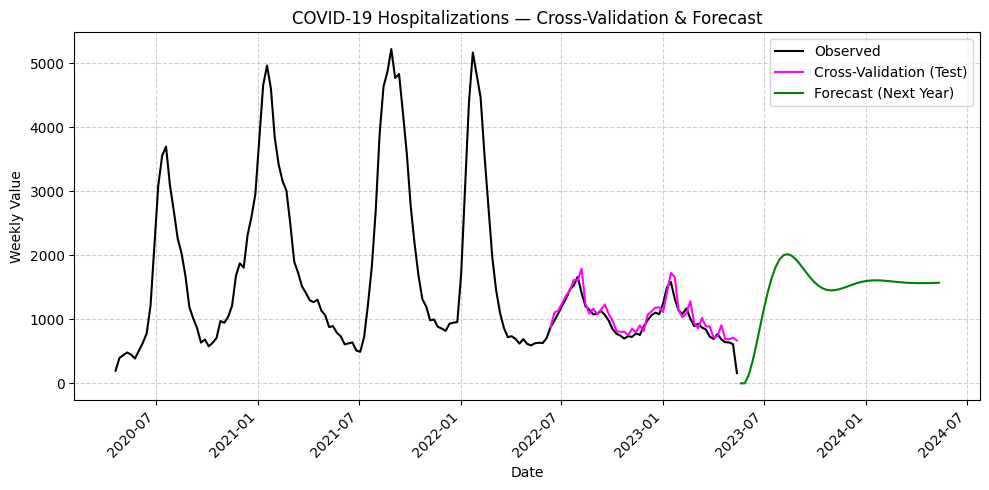


=== COVID HOSPITALIZATIONS (%) ===
Cross-Validation RMSE: 0.04
Historical Peak: 1.56 on 2021-01-10


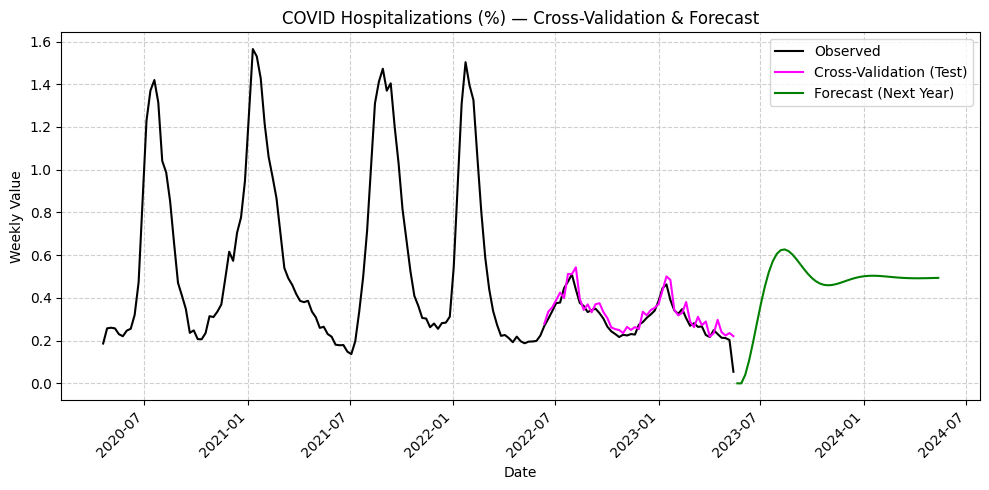


=== ADULT COVID-19 GENERAL ===
Cross-Validation RMSE: 114.05
Historical Peak: 3722.00 on 2022-01-23


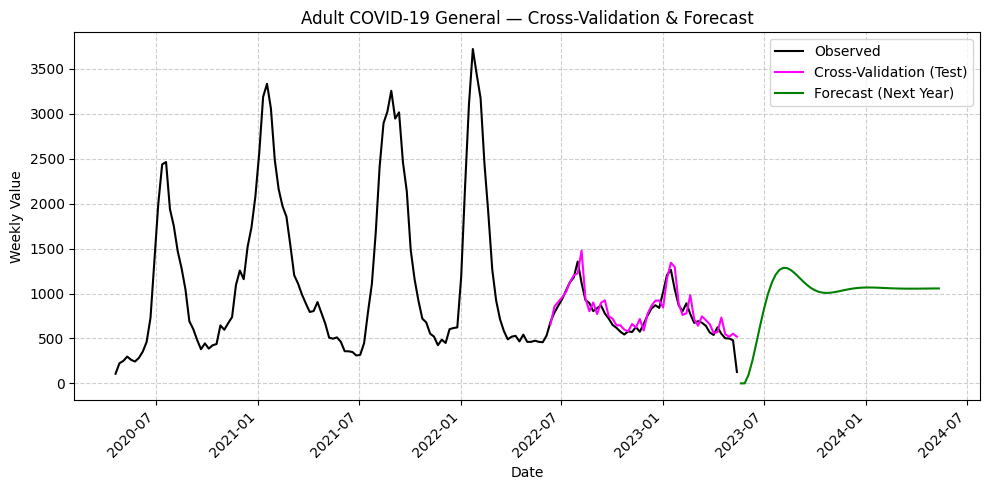


=== ADULT COVID-19 ICU ===
Cross-Validation RMSE: 37.47
Historical Peak: 1844.00 on 2021-08-29


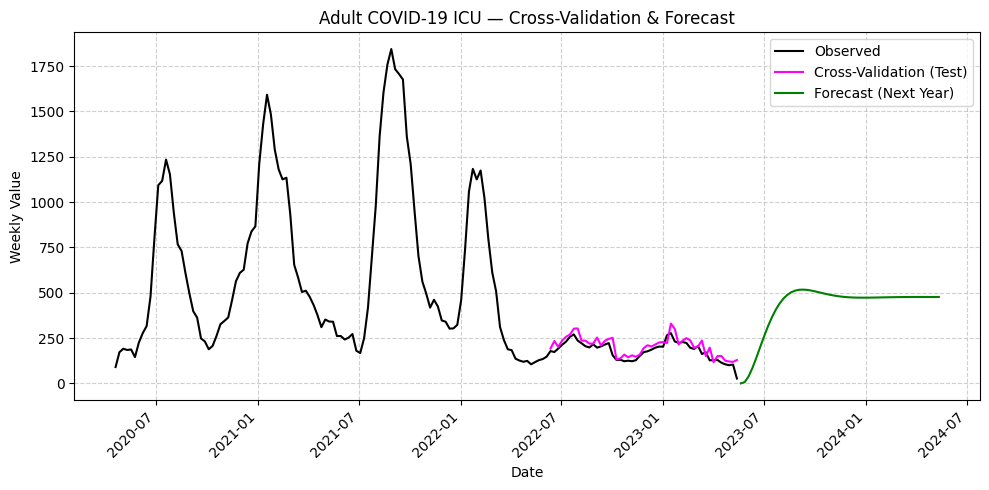


=== PEDIATRIC COVID-19 ===
Cross-Validation RMSE: 11.79
Historical Peak: 262.00 on 2022-01-23


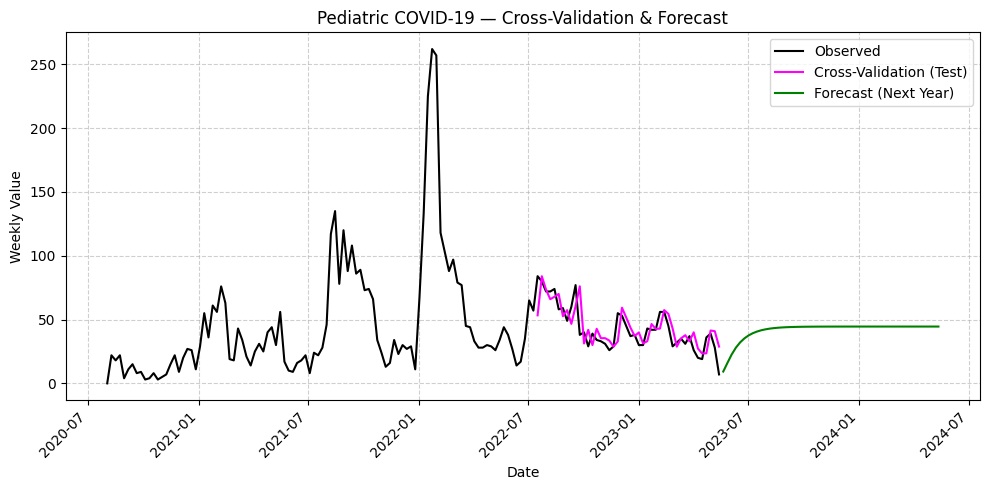


=== COVID-19 ADMITS 24HR ===
Cross-Validation RMSE: 30.85
Historical Peak: 935.00 on 2022-01-23


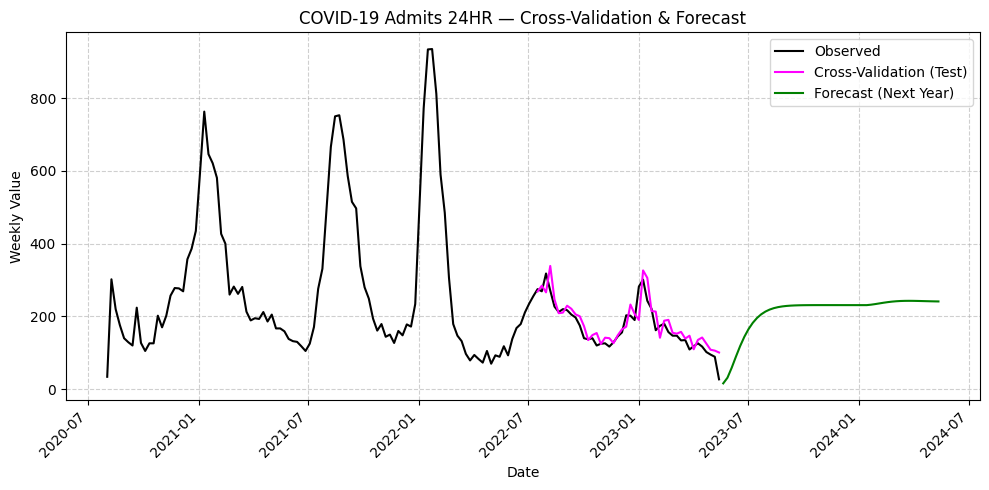


=== TOTAL HOSPITAL CAPACITY ===
Cross-Validation RMSE: 2658.70
Historical Peak: 32452.00 on 2021-07-11


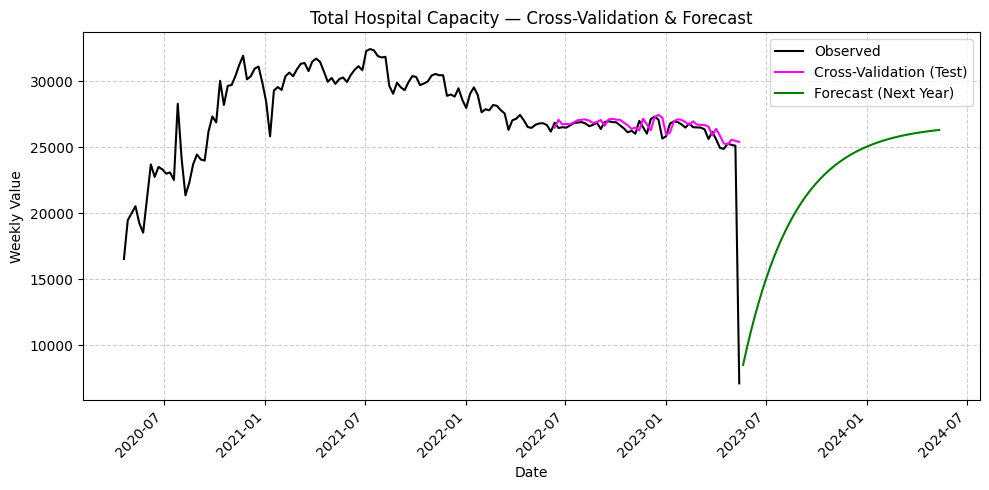


=== COVID % CAPACITY ===
Cross-Validation RMSE: 0.04
Historical Peak: 1.26 on 2021-01-10


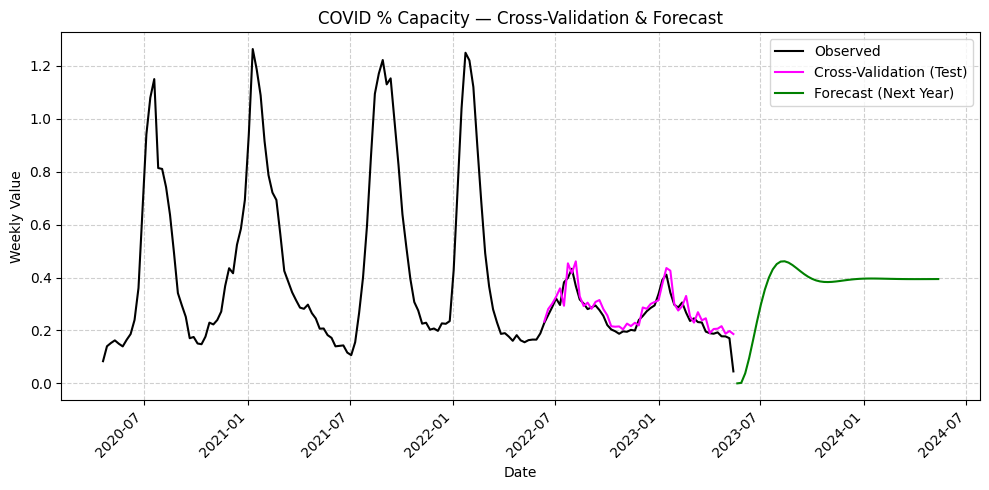


=== TOTAL STAFFED INPATIENT ===
Cross-Validation RMSE: 2610.05
Historical Peak: 30477.00 on 2021-07-11


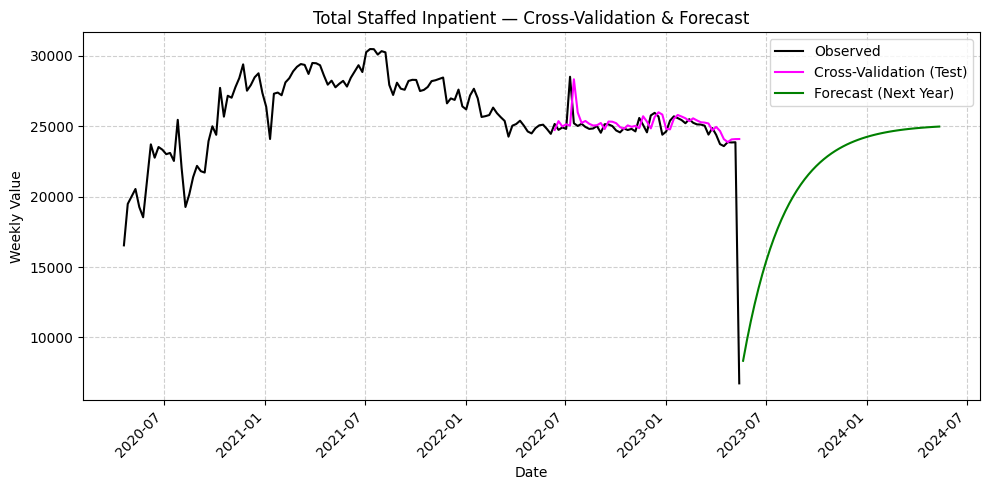


=== TOTAL OCCUPIED BEDS ===
Cross-Validation RMSE: 2254.31
Historical Peak: 26905.00 on 2021-08-08


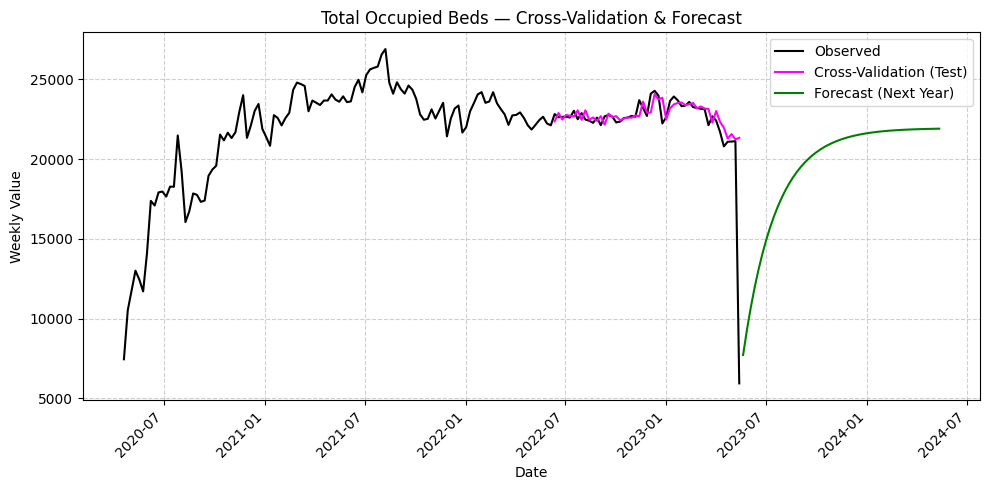


=== TOTAL AVAILABLE BEDS ===
Cross-Validation RMSE: 355.35
Historical Peak: 9091.00 on 2020-04-19


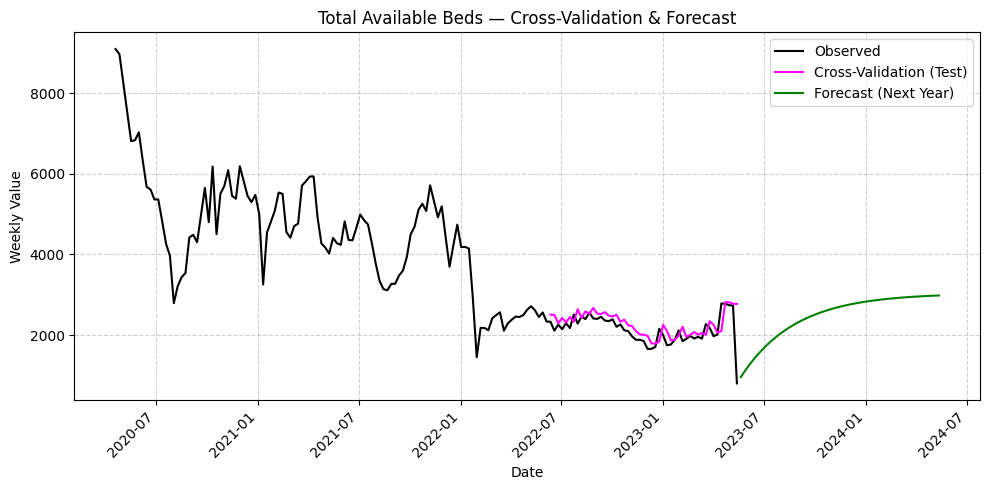


=== ICU BEDS OCCUPIED ===
Cross-Validation RMSE: 282.80
Historical Peak: 3552.00 on 2021-09-05


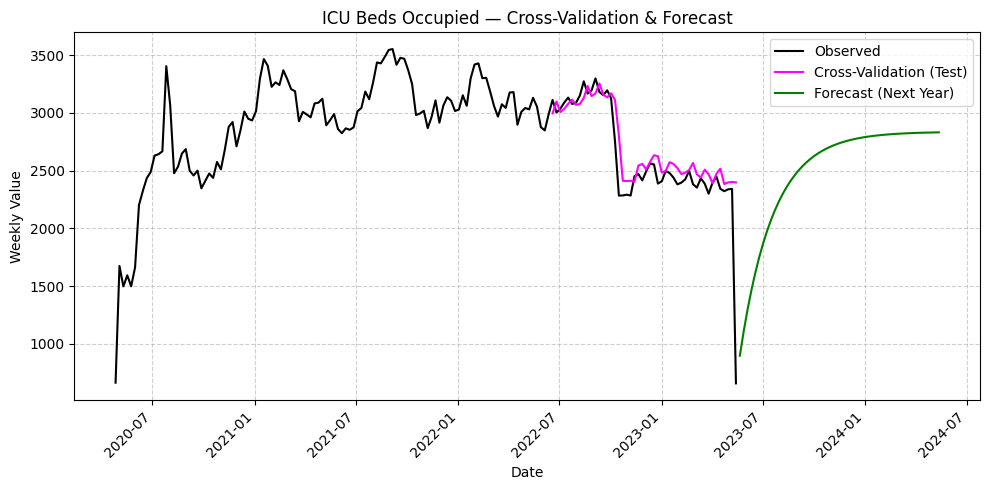


=== ADULT ICU BEDS AVAILABLE ===
Cross-Validation RMSE: 57.96
Historical Peak: 1202.00 on 2020-04-19


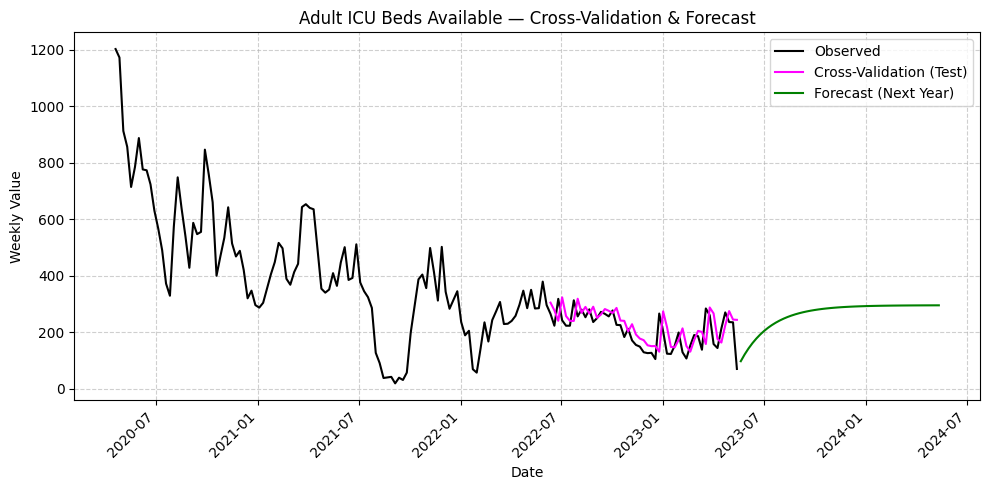


=== PEDIATRIC ICU BEDS AVAILABLE ===
Cross-Validation RMSE: 12.20
Historical Peak: 137.00 on 2020-04-19


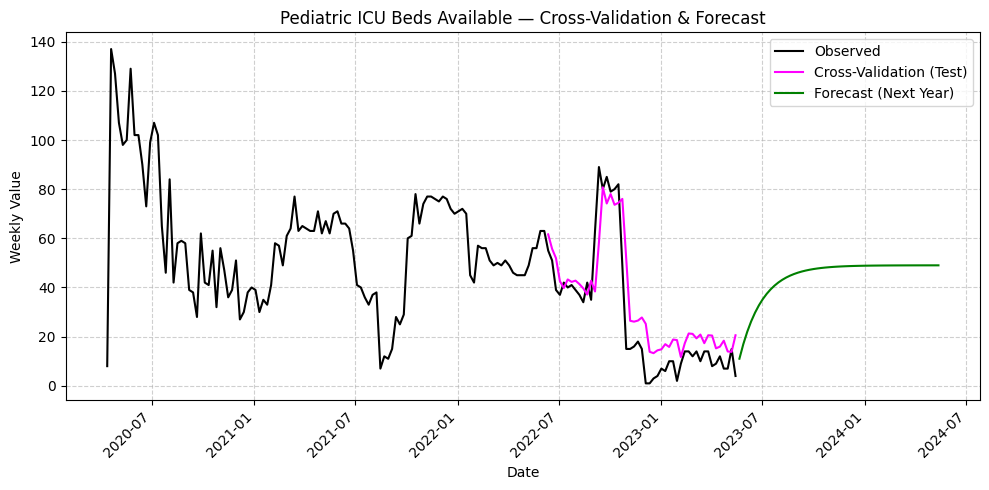


=== COVID19 PATIENTS ON VENTILATORS ===
Cross-Validation RMSE: 41.39
Historical Peak: 2515.00 on 2021-02-07


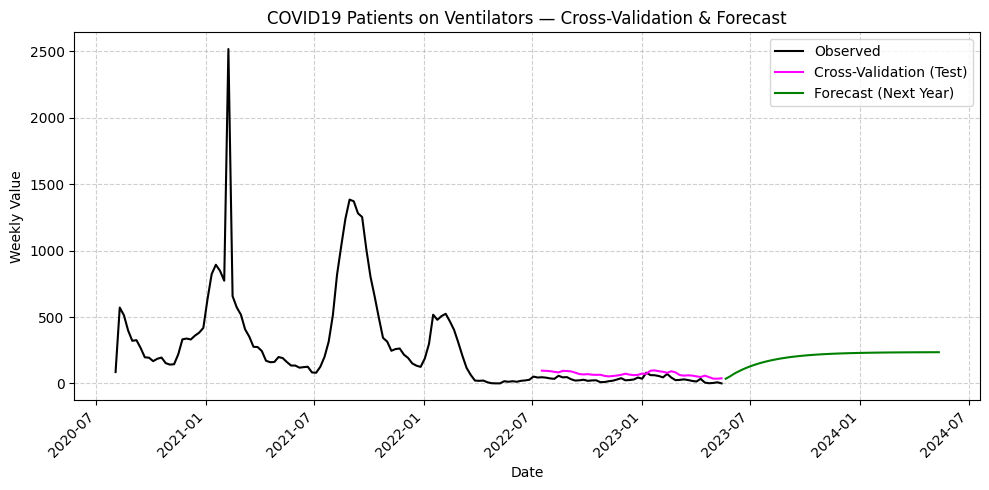


=== AVAILABLE VENTILATORS ===
Cross-Validation RMSE: 295.49
Historical Peak: 3817.00 on 2021-01-24


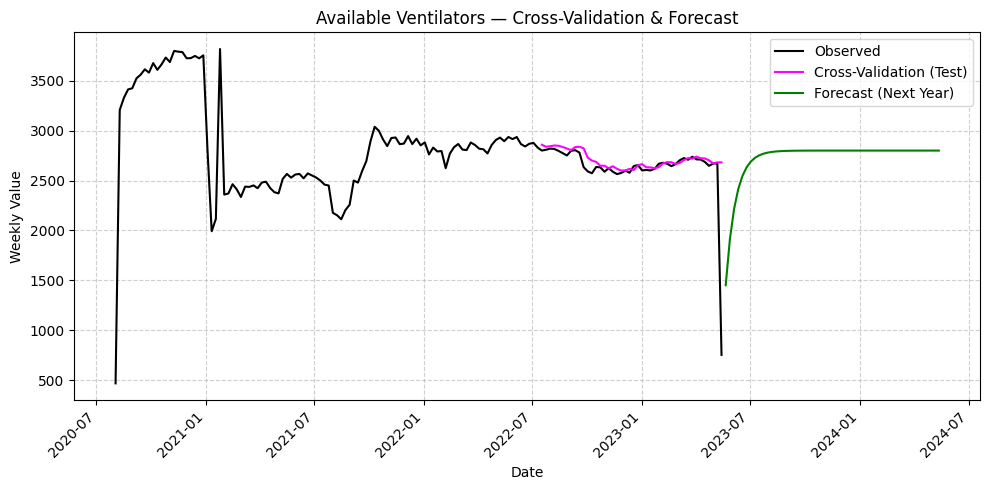


Results for COVID-19 Hospitalizations:
RMSE: 139.49

Results for COVID Hospitalizations (%):
RMSE: 0.04

Results for Adult COVID-19 General:
RMSE: 114.05

Results for Adult COVID-19 ICU:
RMSE: 37.47

Results for Pediatric COVID-19:
RMSE: 11.79

Results for COVID-19 Admits 24HR:
RMSE: 30.85

Results for Total Hospital Capacity:
RMSE: 2658.70

Results for COVID % Capacity:
RMSE: 0.04

Results for Total Staffed Inpatient:
RMSE: 2610.05

Results for Total Occupied Beds:
RMSE: 2254.31

Results for Total Available Beds:
RMSE: 355.35

Results for ICU Beds Occupied:
RMSE: 282.80

Results for Adult ICU Beds Available:
RMSE: 57.96

Results for Pediatric ICU Beds Available:
RMSE: 12.20

Results for COVID19 Patients on Ventilators:
RMSE: 41.39

Results for Available Ventilators:
RMSE: 295.49


In [14]:
# Perform the same Time Series Cross-Validation and Forecasting on Hospitalization Data

# --- Helper function to cross-validate and forecast ---
def cross_validate_forecast(series, title, forecast_weeks=52, max_lag=13):
    print(f"\n=== {title.upper()} ===")
    
    # Split the data
    train = series.iloc[:int(0.7 * len(series))]
    test = series.iloc[int(0.7 * len(series)):]
    
    train_list = train.tolist()
    predictions = []
    
    # --- Cross-validation (rolling forecast) ---
    for i in range(len(test)):
        sel = ar_select_order(train_list, maxlag=max_lag, old_names=False)
        model_fit = sel.model.fit()
        pred = model_fit.predict(start=len(train_list), end=len(train_list), dynamic=False)
        predictions.append(pred[0])
        train_list.append(test.iloc[i])
    
    cross_val = pd.Series(predictions, index=test.index)
    
    # --- RMSE ---
    rmse_cv = np.sqrt(metrics.mean_squared_error(test, cross_val))
    print(f"Cross-Validation RMSE: {rmse_cv:.2f}")
    
    # --- One-year forecast (next 52 weeks) ---
    future_train = series.tolist()
    last_date = series.index[-1]
    future_dates = pd.date_range(start=last_date + pd.Timedelta(weeks=1), periods=forecast_weeks, freq='W')
    
    future_predictions = []
    for i in range(forecast_weeks):
        sel = ar_select_order(future_train, maxlag=max_lag, old_names=False)
        model_fit = sel.model.fit()
        pred = model_fit.predict(start=len(future_train), end=len(future_train), dynamic=False)
        if pred[0] < 0: pred[0] = 0
        future_predictions.append(pred[0])
        future_train.append(pred[0])
    
    future_pred_series = pd.Series(future_predictions, index=future_dates)
    
    # Calculate max value of historical data and annotate with date
    max_hist_val = series.max()
    max_hist_date = series.idxmax()
    print(f"Historical Peak: {max_hist_val:.2f} on {max_hist_date.date()}")
    
    # --- Plot ---
    plt.figure(figsize=(10,5))
    plt.plot(series, label='Observed', color='black')
    plt.plot(cross_val, color='magenta', label='Cross-Validation (Test)')
    plt.plot(future_pred_series, color='green', label='Forecast (Next Year)')
    plt.title(f'{title} — Cross-Validation & Forecast')
    plt.xlabel('Date')
    plt.ylabel('Weekly Value')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
    return cross_val, future_pred_series, rmse_cv

# --- Run for all 6 series ---
results = {}

for name, data in travis_hospital_data.items():
    cross_val, future_pred, rmse = cross_validate_forecast(data.iloc[:,0], name)
    results[name] = {"cv": cross_val, "future": future_pred, "rmse": rmse}
    
# Display results
for name, res in results.items():
    print(f"\nResults for {name}:")
    print(f"RMSE: {res['rmse']:.2f}")